In [17]:
# Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns

In [18]:
#Loading the data
df=pd.read_csv('taxifare.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


## Feature Engineering

In [20]:
import datetime

In [21]:
# UTC time is 4 hours ahead of NYC time
df['pickup_datetime'] =pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(hours=4)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


In [23]:
df['Year']=df['pickup_datetime'].dt.year
df['Month']= df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hour']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute

In [24]:
# Derving part of day 0 means its AM and 1 means its PM
df['part_of_day'] =np.where(df['Hour']<12,0,1)

In [25]:
df.drop(['pickup_datetime'], axis=1, inplace=True)

# Calculating the Haversine Distance for pickup and dropoff locations


In [26]:
def haversine(dataframe):
    latitude1= np.radians(df["pickup_latitude"])
    latitude2= np.radians(df['dropoff_latitude'])
    difference_latitude= np.radians(df['dropoff_latitude']-df['pickup_latitude'])
    difference_longitude= np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    a = np.sin(difference_latitude/2)**2 + np.cos(latitude1) * np.cos(latitude2)*np.sin(difference_longitude/2)**2
    b = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    c= 6371
    return c*b

In [27]:
# Total distance travelled by customer in the taxi
df['Distance_Travelled'] =haversine(df)
#Converting Kilometers to Miles
df['Distance_Travelled'] = df['Distance_Travelled'] /1.6103

In [28]:
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

## Storing Data in MongoDB

In [33]:
!pip install pymongo

   ---------------------------------------- 0.0/483.8 kB ? eta -:--:--
   -- ------------------------------------- 30.7/483.8 kB 1.3 MB/s eta 0:00:01
   ----------------------------- ---------- 358.4/483.8 kB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 483.8/483.8 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 307.7/307.7 kB 9.6 MB/s eta 0:00:00


In [32]:
import json
records=json.loads(df.T.to_json()).values()

In [34]:
import pymongo
client=pymongo.MongoClient('mongodb://localhost:27017/')
db=client['NewYorkTaxi']
col=db['rides']

In [36]:
col.insert_many(records)

InsertManyResult([ObjectId('666cd2c479166cd0c381185f'), ObjectId('666cd2c479166cd0c3811860'), ObjectId('666cd2c479166cd0c3811861'), ObjectId('666cd2c479166cd0c3811862'), ObjectId('666cd2c479166cd0c3811863'), ObjectId('666cd2c479166cd0c3811864'), ObjectId('666cd2c479166cd0c3811865'), ObjectId('666cd2c479166cd0c3811866'), ObjectId('666cd2c479166cd0c3811867'), ObjectId('666cd2c479166cd0c3811868'), ObjectId('666cd2c479166cd0c3811869'), ObjectId('666cd2c479166cd0c381186a'), ObjectId('666cd2c479166cd0c381186b'), ObjectId('666cd2c479166cd0c381186c'), ObjectId('666cd2c479166cd0c381186d'), ObjectId('666cd2c479166cd0c381186e'), ObjectId('666cd2c479166cd0c381186f'), ObjectId('666cd2c479166cd0c3811870'), ObjectId('666cd2c479166cd0c3811871'), ObjectId('666cd2c479166cd0c3811872'), ObjectId('666cd2c479166cd0c3811873'), ObjectId('666cd2c479166cd0c3811874'), ObjectId('666cd2c479166cd0c3811875'), ObjectId('666cd2c479166cd0c3811876'), ObjectId('666cd2c479166cd0c3811877'), ObjectId('666cd2c479166cd0c38118

## Regression Model

In [29]:
df.head()

fare_amount  fare_class  passenger_count  Year  Month  Day  Hour  Minutes  \
0          6.5           0                1  2010      4   19     4       17   
1          6.9           0                1  2010      4   17    11       43   
2         10.1           1                2  2010      4   17     7       23   
3          8.9           0                1  2010      4   11    17       25   
4         19.7           1                1  2010      4   16    22       19   

   part_of_day  Distance_Travelled  
0            0            1.320444  
1            0            0.864626  
2            0            2.065928  
3            1            1.157629  
4            1            4.490667

In [30]:
df.columns

Index(['fare_amount', 'fare_class', 'passenger_count', 'Year', 'Month', 'Day',
       'Hour', 'Minutes', 'part_of_day', 'Distance_Travelled'],
      dtype='object')

In [31]:
#Rearranging the columns
df= df[['fare_class', 'passenger_count', 'Year', 'Month', 'Day',
       'Hour', 'Minutes', 'part_of_day', 'Distance_Travelled','fare_amount']]

In [38]:
x=df.iloc[:,0:-1]
y=df.iloc[:,-1]

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.2,random_state=5)

In [43]:
## Extracting relative importance of each feature on label using ExtraTreesRegresssor
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
regressor=ExtraTreesRegressor()
regressor.fit(x_train,y_train)

ExtraTreesRegressor()

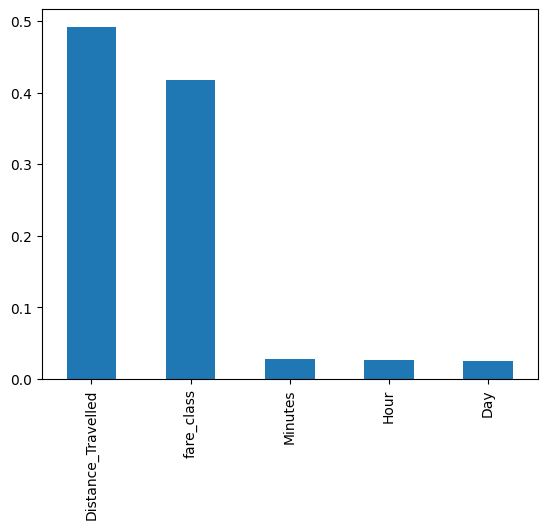

In [44]:
#Plotting graph of 5 top relative feature importances
feature_importances=pd.Series(regressor.feature_importances_,index=x.columns)
feature_importances.nlargest(5).plot(kind='bar')
plt.show()

In [74]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [75]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor()
}


In [76]:
#Randomized Search CV

# Number of trees in Xgboost
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 40, num = 5)]

#Subssample parameter values
subsample=[0.7,0.6,0.8]

# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

In [89]:
# Create the random params
params = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

In [90]:
for name, model in models.items():
    RandomizedSearchCV(estimator = regressor, param_distributions = params,scoring='neg_mean_squared_error', 
                   n_iter =5, cv = 5, verbose=2, random_state=42, n_jobs = -1)



In [91]:
# Parameters setup
parameters = {
    'LinearRegression': {},  # No parameters to tune
    'Ridge': {
        'alpha': [0.1, 1, 10, 100, 1000],
        'solver': ['auto', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': [0.1, 1, 10, 100, 1000],
        'selection': ['cyclic', 'random']
    },
    'RandomForestRegressor': {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 4)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(5, 20, num = 3)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'DecisionTreeRegressor': {
        'max_depth': [int(x) for x in np.linspace(5, 20, num = 3)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 4)],
        'learning_rate': [0.05,0.1, 0.2,0.3],
        'subsample': [0.7, 0.8, 0.9],
        'max_depth': [int(x) for x in np.linspace(5, 20, num = 3)]
    },
    'XGBRegressor': {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 4)],
        'learning_rate': [0.05,0.1, 0.2,0.3],
        'subsample': [0.7, 0.8, 0.9],
        'max_depth': [int(x) for x in np.linspace(5, 20, num = 3)],
        'min_child_weight': [1, 2, 3, 4]
    }
}


In [92]:
# Apply RandomizedSearchCV or GridSearchCV based on model compatibility
for name, model in models.items():
    print(f"Processing {name}...")
    param_distributions = parameters[name]
    # Use RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3,
                                       scoring='neg_mean_squared_error', verbose=2, random_state=42, n_jobs=-1)


Processing LinearRegression...
Processing Ridge...
Processing Lasso...
Processing RandomForestRegressor...
Processing DecisionTreeRegressor...
Processing GradientBoostingRegressor...
Processing XGBRegressor...


In [93]:
random_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3],
                                        'max_depth': [5, 12, 20],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 466, 833, 1200],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [95]:

print(f"Best parameters from RandomizedSearchCV for {name}: {random_search.best_params_}")



Best parameters from RandomizedSearchCV for XGBRegressor: {'subsample': 0.9, 'n_estimators': 466, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05}


# Artificial Neural Networks

In [96]:
x_train.shape[0]

24000

In [98]:

# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU
from tensorflow.keras.layers import Dropout

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

# Fitting the ANN to the Training set
model_history=NN_model.fit(X_train, y_train,validation_split=0.33, batch_size = 10, epochs = 20)